# How Word Embeddings Effect NLP Models

This notebook will explore come different feature selection methods for NLP models. It will cover the following topics:

- Tokenisation
- Stopwords
- Zipfian Distributions
- Sentiment Analysis
- Bag-of-words Vectorisation
- tf\*idf Vectorisation
- Subword Encoding
- Word Embeddings

## About Me

My name is Ryan Callihan. I am a native of San Diego, California but moved to the sunnier climes of Lancaster, UK.

I am:

- Senior Computational Linguist at [Relative Insight](https://relativeinsight.com/)
- Organiser of [PyData Lancaster](https://twitter.com/PydataLancaster)
- Co-founder of [Coin Market Mood](https://coinmarketmood.com/)
- [collector of old post cards](https://postrecollection.wordpress.com/)

You can find me on:
- [Twitter](https://twitter.com/_ryancallihan)
- [LinkedIn](https://www.linkedin.com/in/ryan-callihan/)
- [Github](https://github.com/ryancallihan)
- [Instagram](https://www.instagram.com/ryancallihan/)

![Relative Insight](https://raw.githubusercontent.com/ryancallihan/nlp-feature-selection/master/images/RelativeLogo_RGB.png)

In [ ]:
%%capture
!pip install unidecode

import os
from string import punctuation
from collections import Counter

import nltk
import numpy as np
import pandas as pd
from tqdm import tqdm
from string import punctuation
from nltk import word_tokenize
from unidecode import unidecode
from nltk.corpus import stopwords

# Models necessary for this workshop
!python -m spacy download en_core_web_md
nltk.download('punkt')
nltk.download('stopwords')

# Download data
!wget https://raw.githubusercontent.com/ryancallihan/nlp-feature-selection/master/data/imdb-sentiment-train.csv
!wget https://raw.githubusercontent.com/ryancallihan/nlp-feature-selection/master/data/imdb-sentiment-test.csv

We will be removeing stopwords for some of these methods. [Stopwords](https://en.wikipedia.org/wiki/Stop_words) are words which, at a basic level, do not carry much "_meaning_". Words like: _the_, _and_, _or_, _is_, etc. I have included most punctuation in this as well.

In [ ]:
stopwords = stopwords.words('english') + list(punctuation)

## Data 

The data we will be looking at is the classic [IMDB Sentiment Analysis](https://ai.stanford.edu/~amaas/data/sentiment/) dataset. It is a cleaned up sentiment analysis dataset, consisting of film reviews from IMDB. Each review is given a binary score of _Positive_ or _Negative_. It has already been divided into 25k train and 25k validation sets.

We will only be taking 10K samples for the validation because of RAM and time contraints

In [ ]:
train_df = pd.read_csv('imdb-sentiment-train.csv')
test_df = pd.read_csv('imdb-sentiment-test.csv').sample(10000)

### Preprocessing

Convert to ASCII for ease during this presentation. Will convert characters like `Ü` to `U`. It just reduces the unique token types for this workshop.

In [ ]:
train_df.text = [unidecode(t) for t in train_df.text]
test_df.text = [unidecode(t) for t in test_df.text]

[Tokenization](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization) is breaking up the text into usable pieces.

A sentence like `'I don't like celery.'` might be tokenized as `['I', 'do', 'n't', 'like', 'celery', '.']`

Do a simple tokenize on the texts for ease using NLTK's [`word_tokenize`](https://www.nltk.org/api/nltk.tokenize.html)

In [5]:
train_df['tokenized'] = [[t for t in word_tokenize(r.lower()) if t not in stopwords] for r in tqdm(train_df.text)]
test_df['tokenized'] = [[t for t in word_tokenize(r.lower()) if t not in stopwords] for r in tqdm(test_df.text)]

100%|██████████| 10000/10000 [00:21<00:00, 467.13it/s]


In [1]:
# train_df.head()

## Some Minor Data Exporation

It's always good to look at the data at least a little bit before working with it.

### Class Split

The classes are evenly split, so class imbalance won't be a problem.

- `0` == _Negative_
- `1` == _Positive_

1    12500
0    12500
Name: sentiment, dtype: int64


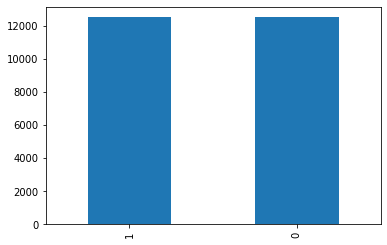

In [7]:
print(train_df.sentiment.value_counts())
train_df.sentiment.value_counts().plot.bar()

### Review Length

We can see that the majority of reviews are roughly under 500 tokens long. Because we will be doing sentiment using a _Feed Forward_ network, we will not really need to worry about sequence length. When dealing with _Recurrent_ models, _Attention_ models, etc., it would need to be taken into consideration.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc115293128>]],
      dtype=object)

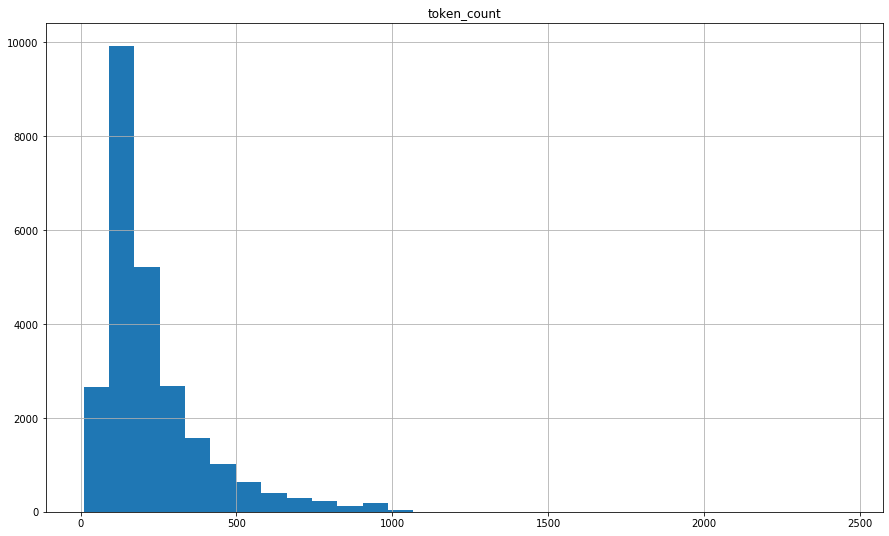

In [8]:
train_df['token_count'] = [len(t.split()) for t in train_df['text']]
test_df['token_count'] = [len(t.split()) for t in test_df['text']]
train_df.hist(column='token_count', bins=30, figsize=(15, 9))

### Distribution of tokens

Token counts in a dataset usually have a [Zipfian Distribution](https://en.wikipedia.org/wiki/Zipf%27s_law) where the frequency of a token is inversely proportional to its rank.

The majority of _stopwords_ have a really high frequency whereas content words usually dont.

This is important for a couple of the feature extraction methods. Having a very large vocabulary can make your feature matrices especially large. 

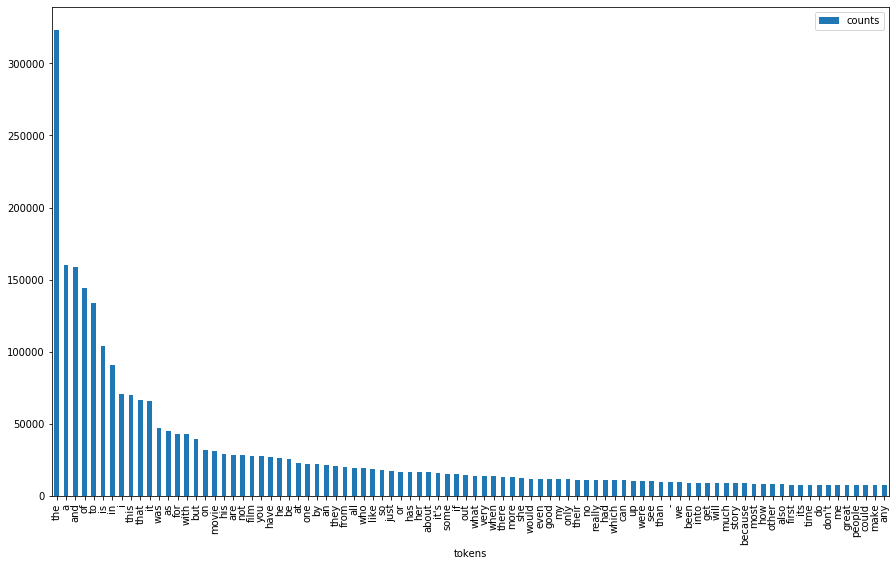

In [9]:
# Get token counts
tokens, counts = zip(*sorted(Counter([t.lower() for s in train_df.text for t in s.split()]).items(), key=lambda x: x[1])[::-1])
df = pd.DataFrame({
    'tokens': tokens,
    'counts': counts
})
df.sort_index(ascending=True).head(90).plot.bar(x='tokens', y='counts', figsize=(15, 9))

Our dataset certainly seems to follow a Zipfian distribution. For the sake of resources, we can limit our vocabulary by the frequency of tokens. We can remove stopwords and limit our vocab by frequency.

Even after doing that, our dataset still fits the _Zipfian_ distribution.

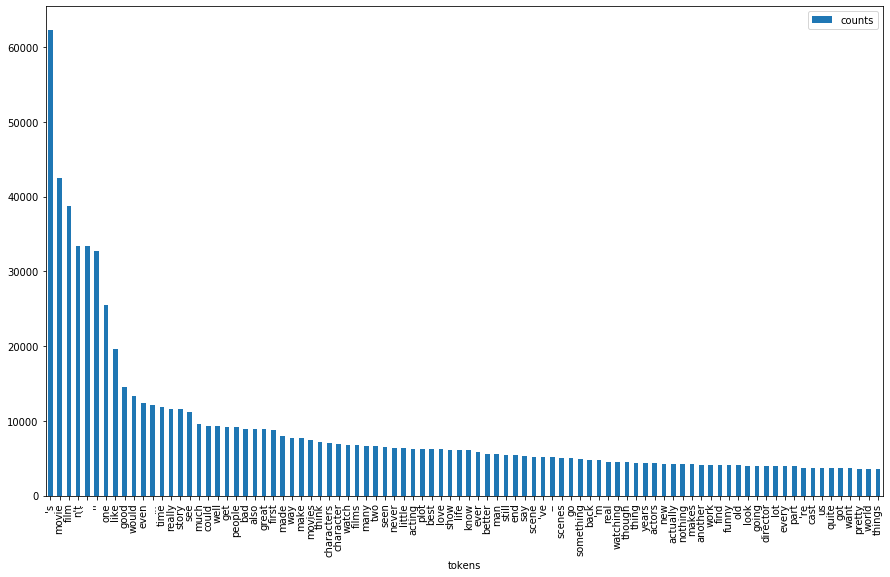

In [10]:
# Get token counts
tokens, counts = zip(*sorted(Counter([t for s in train_df.tokenized for t in s]).items(), key=lambda x: x[1])[::-1])
df = pd.DataFrame({
    'tokens': tokens,
    'counts': counts
})

df.sort_index(ascending=True).head(90).plot.bar(x='tokens', y='counts', figsize=(15, 9))

## Testing Model

We will be testing our feature extraction on a _Feed Forward_ neural net. We will be using a [_Keras_](https://www.tensorflow.org/guide/keras) model for ease.

We will use a model with the following hyperparams:

- _Learning Rate_ == 0.0001
- _Optimizer_ == _Adam_
- _Layer Activations_ == _Sigmoid_
- _Loss_ == _Binary Crossentropy_

```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
dense (Dense)             (None, 128)               2560128   
_________________________________________________________________
dropout (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_0 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_0 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)             (None, 1)                 65        
=================================================================
Total params: 2,576,769
Trainable params: 2,576,769
Non-trainable params: 0
_________________________________________________________________
```

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
def build_model(vector_length):
    np.random.seed(42)
    model = Sequential()
    model.add(Dense(128, activation='sigmoid', input_shape=(vector_length, )))
    model.add(Dropout(0.3))
    for _ in range(3):
        model.add(Dense(64, activation='sigmoid'))
        model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    adam = Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    # print(model.summary())
    return model

## Bag-of-Words Encoding

Bag-of-Words (BOW) encoding creates vectors for words in which the length of the vector is the size of the vocabulary, and each token has an index. These vectors are very sparse. Most of the elements are 0.

In [13]:
corpus = [
  ['I', 'like', 'cheese', '.'],
  ['We', 'like', 'stinky', 'cheese', '.'],
  ['They', 'do', 'not', 'like', 'stinky', 'cheese', '!'],
  ['I', 'like', 'stinky', 'cheese', 'but', 'not', 'mild', 'cheese', '.']
]
vocab = set(t for s in corpus for t in s)
indexer = {t: i for i, t in enumerate(vocab)}
vocab_len = len(vocab)
indexer

{'!': 7,
 '.': 10,
 'I': 1,
 'They': 6,
 'We': 8,
 'but': 5,
 'cheese': 9,
 'do': 0,
 'like': 2,
 'mild': 3,
 'not': 11,
 'stinky': 4}

We can turn our sentences into vectors

In [14]:
sent_i = 0
vec = np.zeros(vocab_len)
for t in corpus[sent_i]:
    vec[indexer[t]] += 1
vec

array([0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.])

And then reversed. However, we can't preserve order.

In [15]:
indexer_inverse = {v: k for k, v in indexer.items()}
for i, v in enumerate(vec):
    if v:
        print(f'Token: {indexer_inverse[i]:<7} | Count: {int(v)}')

Token: I       | Count: 1
Token: like    | Count: 1
Token: cheese  | Count: 1
Token: .       | Count: 1


[_Scikit-Learn_](https://scikit-learn.org/) is a good implementation of of this.

We will limit the total vocabulary to 20k. It will prioritize tokens with a higher frequency.

#### [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

def dummy_func(doc):
  """Must pass a dummy function to avoid sklearn automatically tokenizing."""
  return doc

one_hot = CountVectorizer(preprocessor=dummy_func, tokenizer=dummy_func, min_df=5, max_features=20000)
one_hot.fit(train_df.tokenized)
print(f'Feature Dimensions: {(len(train_df), len(one_hot.vocabulary_))}')

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Feature Dimentions: (25000, 20000)


It's pretty easy to use

In [17]:
print(f'Text: {train_df.text.values[0][:50]}')
vec = one_hot.transform([train_df.tokenized.values[0]]).toarray()
print(f'Feature Dimensions: {vec.shape}')
vec

Text: Steven Spielberg (at 24) had already directed two 
Feature Dimentions: (1, 20000)


array([[14,  0,  0, ...,  0,  0,  0]])

### Training

In [18]:
oh_model = build_model(len(one_hot.vocabulary_))
oh_history = oh_model.fit(
    x=one_hot.transform(train_df.tokenized), 
    y=train_df.sentiment,
    epochs=10,
    validation_data=(one_hot.transform(test_df.tokenized), test_df.sentiment)
    )

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 25000 samples, validate on 10000 samples
Epoch 1/10
25000/25000 [==============================] - 11s 450us/sample - loss: 0.7267 - acc: 0.5044 - val_loss: 0.6814 - val_acc: 0.7477
Epoch 2/10
25000/25000 [==============================] - 11s 429us/sample - loss: 0.6394 - acc: 0.6238 - val_loss: 0.4614 - val_acc: 0.8583
Epoch 3/10
25000/25000 [==============================] - 11s 429us/sample - loss: 0.3693 - acc: 0.8570 - val_loss: 0.2994 - val_acc: 0.8801
Epoch 4/10
25000/25000 [==============================] - 11s 431us/sample - loss: 0.2771 - acc: 0.8944 - val_loss: 0.2812 - val_acc: 0.8856
Epoch 5/10
25000/25000 [==============================] - 11s 430us/sample - loss: 0.2362 - acc: 0.9121 - val_loss: 0.2787 - val_acc: 0.8886
Epoch 6/10
25000/25000 [==============================] - 11s 430us/sa

### Prediction

In [19]:
def oh_predict(text):
  return oh_model.predict(one_hot.transform([text.lower().split()]))[0][0]

def oh_print(text):
  print(f'{oh_predict(text):<.5f} | {text}')

t1 = '''Tacos in England is absolutely terrible .'''
t2 = '''Tacos in England absolutely terible .'''
t3 = '''Tacos in Prague are not so bad .'''
t4 = '''Mexican food in SD is the best .'''
t5 = '''I'm a big fan of tacos .'''

oh_print(t1)
oh_print(t2)
oh_print(t3)
oh_print(t4)
oh_print(t5)

0.17458 | Tacos in England is absolutely terrible .
0.57092 | Tacos in England absolutely terible .
0.18041 | Tacos in Prague are not so bad .
0.64227 | Mexican food in SD is the best .
0.43182 | I'm a big fan of tacos .


## TF*IDF

[_tf*idf_](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) is a widely used technique in NLP for feature and keyword extraction. 

By combining the frequency (how many times a term appears in a document) by the inverse document frequency (how many documents a term appears in), we are able to filter out common words and promote unique content words.

[_Scikit-Learn_](https://scikit-learn.org/) also has a very good implementation of it.

#### [`TFIDFVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(preprocessor=dummy_func, tokenizer=dummy_func, min_df=5, max_features=20000)
tfidf.fit(train_df.tokenized)
print(f'Feature Dimensions: {(len(train_df), len(tfidf.vocabulary_))}')

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Feature Dimensions: (25000, 20000)


### Training

In [21]:
tfidf_model = build_model(len(tfidf.vocabulary_))
tfidf_history = tfidf_model.fit(
    x=tfidf.transform(train_df.tokenized), 
    y=train_df.sentiment,
    epochs=10,
    validation_data=(tfidf.transform(test_df.tokenized), test_df.sentiment)
    )

Train on 25000 samples, validate on 10000 samples
Epoch 1/10
25000/25000 [==============================] - 11s 457us/sample - loss: 0.7309 - acc: 0.4942 - val_loss: 0.6929 - val_acc: 0.5009
Epoch 2/10
25000/25000 [==============================] - 11s 433us/sample - loss: 0.7133 - acc: 0.5060 - val_loss: 0.6927 - val_acc: 0.5009
Epoch 3/10
25000/25000 [==============================] - 11s 433us/sample - loss: 0.7085 - acc: 0.5038 - val_loss: 0.6929 - val_acc: 0.4991
Epoch 4/10
25000/25000 [==============================] - 11s 430us/sample - loss: 0.7073 - acc: 0.5016 - val_loss: 0.6921 - val_acc: 0.6794
Epoch 5/10
25000/25000 [==============================] - 14s 569us/sample - loss: 0.7016 - acc: 0.5012 - val_loss: 0.6913 - val_acc: 0.7649
Epoch 6/10
25000/25000 [==============================] - 15s 584us/sample - loss: 0.6978 - acc: 0.5131 - val_loss: 0.6896 - val_acc: 0.4991
Epoch 7/10
25000/25000 [==============================] - 15s 585us/sample - loss: 0.6915 - acc: 0.5291 

### Prediction

In [22]:
def tfidf_predict(text):
  return tfidf_model.predict(tfidf.transform([text.lower().split()]))[0][0]

def tfidf_print(text):
  print(f'{tfidf_predict(text):<.5f} | {text}')

tfidf_print(t1)
tfidf_print(t2)
tfidf_print(t3)
tfidf_print(t4)
tfidf_print(t5)

0.27939 | Tacos in England is absolutely terrible .
0.71295 | Tacos in England absolutely terible .
0.34786 | Tacos in Prague are not so bad .
0.79958 | Mexican food in SD is the best .
0.72528 | I'm a big fan of tacos .


## Subword Encoding

Also known as [_Byte Pair Encoding_](https://en.wikipedia.org/wiki/Byte_pair_encoding). This feature extraction has become very popular in the past couple years. Because writing is frequently non-standard, BOW encoding is often not ideal. Because BOW and tfidf encoding require a static vocabulary, it cannot handle new words, misspelled words, etc. If the vocabulary was built to include _terrible_ but not _terrible_, it could have a negative effect on the model.

_Byte Pair Encoding_ starts by looking at the training dataset on a character level. It find the most frequent pairs of characters, registers that as a subword, and then will treat each occurence of that sequence as one unit. 

- `H e r e  i s  a  n i c e  s e n t e n c e .`
- `H e r e  i s  a  n i c e  s en t en c e .`
- `H e r e  i s  a  n i ce  s en t en ce .`
- ...

This is able to capture things like word stems and morphology.

Tensorflow as a good and efficient implementation of this.

#### [`SubwordTextEncoder`](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder)

In [28]:
import tensorflow_datasets as tfds

swe_encoder = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    train_df.text, target_vocab_size=20000)
print(f'Feature Dimensions: {(len(train_df), swe_encoder.vocab_size)}')

Feature Dimentions: (25000, 20068)


We can see how it splits up text here.

In [31]:
text = 'Here is a standard sentence.'  # Standard Words
# text = 'This sentence is more standarder!'  # Non-standard word
enc = swe_encoder.encode(text)
print(f'Encoded: {enc}', '\n', '-'*10)
for e in enc:
    print(f'Decoded: {swe_encoder.decode([e])}')

Encoded: [1668, 8, 4, 1945, 9051, 19858] 
 ----------
Decoded: Here 
Decoded: is 
Decoded: a 
Decoded: standard 
Decoded: sentence
Decoded: .


However, we still need to convert our Subword encodings into vectors. They will function just like the one-hot vectors

In [ ]:
swe_train_x = np.zeros((len(train_df), swe_encoder.vocab_size))
for i, text in enumerate(train_df.text):
    for e in swe_encoder.encode(text):
        swe_train_x[i, e] += 1

swe_test_x = np.zeros((len(test_df), swe_encoder.vocab_size))
for i, text in enumerate(test_df.text):
    for e in swe_encoder.encode(text):
        swe_test_x[i, e] += 1

### Training

In [33]:
swe_model = build_model(swe_encoder.vocab_size)

swe_history = swe_model.fit(
    x=swe_train_x, 
    y=train_df.sentiment,
    epochs=10,
    validation_data=(swe_test_x, test_df.sentiment)
    )

Train on 25000 samples, validate on 10000 samples
Epoch 1/10
25000/25000 [==============================] - 11s 444us/sample - loss: 0.7141 - acc: 0.5023 - val_loss: 0.6777 - val_acc: 0.7631
Epoch 2/10
25000/25000 [==============================] - 11s 436us/sample - loss: 0.6086 - acc: 0.6704 - val_loss: 0.4312 - val_acc: 0.8562
Epoch 3/10
25000/25000 [==============================] - 11s 434us/sample - loss: 0.3430 - acc: 0.8742 - val_loss: 0.3035 - val_acc: 0.8817
Epoch 4/10
25000/25000 [==============================] - 11s 435us/sample - loss: 0.2469 - acc: 0.9112 - val_loss: 0.2887 - val_acc: 0.8876
Epoch 5/10
25000/25000 [==============================] - 11s 433us/sample - loss: 0.2059 - acc: 0.9270 - val_loss: 0.2901 - val_acc: 0.8882
Epoch 6/10
25000/25000 [==============================] - 11s 434us/sample - loss: 0.1728 - acc: 0.9416 - val_loss: 0.2976 - val_acc: 0.8886
Epoch 7/10
25000/25000 [==============================] - 11s 431us/sample - loss: 0.1508 - acc: 0.9498 

### Prediction

In [34]:
def swe_predict(text):
    x = np.zeros((1, swe_encoder.vocab_size))
    for e in swe_encoder.encode(text):
        x[0, e] += 1
    return swe_model.predict(x)[0][0]

def swe_print(text):
    print(f'{swe_predict(text):<.5f} | {text}')

swe_print(t1)
swe_print(t2)
swe_print(t3)
swe_print(t4)
swe_print(t5)

0.09552 | Tacos in England is absolutely terrible .
0.65735 | Tacos in England absolutely terible .
0.07198 | Tacos in Prague are not so bad .
0.61209 | Mexican food in SD is the best .
0.55832 | I'm a big fan of tacos .


## GloVe

_Word Embeddings_ are now the new normal for NLP. Two of the first, widely used, and really successful embedding algorithms were [_GloVe_](https://nlp.stanford.edu/projects/glove/) and [_Word2Vec_](https://en.wikipedia.org/wiki/Word2vec). We will be using _GloVe_ here because it is so easy to use with [_spaCy_](https://spacy.io/)

Word embeddings start to fix a couple major problem with one-hot and tfidf. 

- __Dimentionality Reduction__: The vectors we used earlier are quite large with a dimention of 20k. _GloVe_ vectors have a dimention of 300. 
- __Semantics__: _"You shall know a word by the company it keeps"_ (Firth). These vectors will group words which have a similar meaning together. So, a word like "_bad_" will be close to "_terrible_", similar to "_good_", but very dissimilar to "_taco_".

We will be using [_spaCy_](https://spacy.io/) to load our vectors

In [ ]:
import en_core_web_md  # There are easier ways to import spacy models, but not for colab
from spacy.tokens import Doc

In [ ]:
nlp = en_core_web_md.load(disable=['tagger', 'parser', 'ner'])

In [37]:
doc = nlp('Tacos are my favourite food.')
print(doc[0].vector)
print(f'Feature Dimensions: {(len(train_df), doc[0].vector.shape[0])}')

[-2.5613e-01 -5.8044e-01  7.3699e-01  1.0224e-01  3.0633e-01  8.2543e-01
  2.0214e-02  7.2938e-02  4.0591e-01  5.0618e-01  1.8421e-01  4.6015e-01
  3.3065e-01 -1.5053e-01  6.3065e-02 -4.4431e-01 -7.1902e-02  1.9935e-01
 -5.2998e-02  3.1779e-01 -1.4263e-01  1.5533e-01  3.3776e-01 -1.5319e-01
 -8.7850e-02  1.4125e-01 -6.4250e-01 -2.0063e-02  3.8200e-01 -2.3199e-01
  7.0890e-01 -3.3531e-01  4.7066e-01 -8.0234e-01 -2.6422e-01 -1.9988e-02
  2.1466e-01 -2.0214e-01  1.2551e-01  1.3106e+00 -3.6580e-01  3.1551e-01
  4.1100e-01  2.3948e-01  2.3006e-01  7.2661e-01  1.0138e-01  3.9562e-01
  1.0115e-01 -4.7646e-02 -3.2069e-01  5.6321e-01  2.8439e-01 -2.0420e-01
  6.3218e-01  8.1519e-02 -3.3584e-01  4.2714e-01  3.9305e-01  4.2263e-01
  7.5474e-01 -2.4415e-01  1.6967e-01  6.3332e-01  6.7876e-01 -1.2870e+00
  8.0630e-01 -2.1743e-01 -2.0185e-01  6.2304e-01 -1.1730e-01  5.7444e-01
 -2.4795e-01  9.7829e-02 -2.4434e-01 -3.3781e-01 -2.9350e-01 -3.3287e-01
  3.4759e-01  8.3573e-02 -1.7077e-01 -6.4838e-02  3

In [ ]:
glove_train_x = np.array([Doc(nlp.vocab, words=sent).vector.tolist() for sent in tqdm(train_df.tokenized, disable=True)])
glove_test_x = np.array([Doc(nlp.vocab, words=sent).vector.tolist() for sent in tqdm(test_df.tokenized, disable=True)])

### Training

In [ ]:
glove_model = build_model(300)

In [40]:
glove_history = glove_model.fit(
    x=glove_train_x, 
    y=train_df.sentiment,
    epochs=10,
    validation_data=(glove_test_x, test_df.sentiment)
    )

Train on 25000 samples, validate on 10000 samples
Epoch 1/10
25000/25000 [==============================] - 2s 96us/sample - loss: 0.7113 - acc: 0.5029 - val_loss: 0.6922 - val_acc: 0.5009
Epoch 2/10
25000/25000 [==============================] - 2s 86us/sample - loss: 0.7059 - acc: 0.4998 - val_loss: 0.6900 - val_acc: 0.5022
Epoch 3/10
25000/25000 [==============================] - 2s 86us/sample - loss: 0.6970 - acc: 0.5197 - val_loss: 0.6775 - val_acc: 0.7121
Epoch 4/10
25000/25000 [==============================] - 2s 86us/sample - loss: 0.6574 - acc: 0.6154 - val_loss: 0.5790 - val_acc: 0.7667
Epoch 5/10
25000/25000 [==============================] - 2s 85us/sample - loss: 0.5425 - acc: 0.7441 - val_loss: 0.4668 - val_acc: 0.7897
Epoch 6/10
25000/25000 [==============================] - 2s 86us/sample - loss: 0.4885 - acc: 0.7757 - val_loss: 0.4380 - val_acc: 0.7992
Epoch 7/10
25000/25000 [==============================] - 2s 86us/sample - loss: 0.4745 - acc: 0.7827 - val_loss: 0.

### Prediction

In [41]:
def glove_predict(text):
  x = np.array([Doc(nlp.vocab, words=text.lower().split()).vector.tolist()])
  return glove_model.predict(x)[0][0]

def glove_print(text):
  print(f'{swe_predict(text):<.5f} | {text}')

swe_print(t1)
swe_print(t2)
swe_print(t3)
swe_print(t4)
swe_print(t5)

0.09552 | Tacos in England is absolutely terrible .
0.65735 | Tacos in England absolutely terible .
0.07198 | Tacos in Prague are not so bad .
0.61209 | Mexican food in SD is the best .
0.55832 | I'm a big fan of tacos .


## Conclusion

This was by no means a comprehensive comparison of NLP feature selection. But we can see that the features we use can make a large difference

In [42]:
print(f"{'O-H':<5} | {'TFIDF':<5} | {'SWE':<5} | {'GloVe':<5} | {'Text'}")
print(f"{oh_predict(t1):.3f} | {tfidf_predict(t1):.3f} | {swe_predict(t1):.3f} | {glove_predict(t1):.3f} | {t1}")
print(f"{oh_predict(t2):.3f} | {tfidf_predict(t2):.3f} | {swe_predict(t2):.3f} | {glove_predict(t2):.3f} | {t2}")
print(f"{oh_predict(t3):.3f} | {tfidf_predict(t3):.3f} | {swe_predict(t3):.3f} | {glove_predict(t3):.3f} | {t3}")
print(f"{oh_predict(t4):.3f} | {tfidf_predict(t4):.3f} | {swe_predict(t4):.3f} | {glove_predict(t4):.3f} | {t4}")
print(f"{oh_predict(t5):.3f} | {tfidf_predict(t5):.3f} | {swe_predict(t5):.3f} | {glove_predict(t5):.3f} | {t5}")

O-H   | TFIDF | SWE   | GloVe | Text
0.175 | 0.279 | 0.096 | 0.196 | Tacos in England is absolutely terrible .
0.571 | 0.713 | 0.657 | 0.079 | Tacos in England absolutely terible .
0.180 | 0.348 | 0.072 | 0.169 | Tacos in Prague are not so bad .
0.642 | 0.800 | 0.612 | 0.938 | Mexican food in SD is the best .
0.432 | 0.725 | 0.558 | 0.896 | I'm a big fan of tacos .


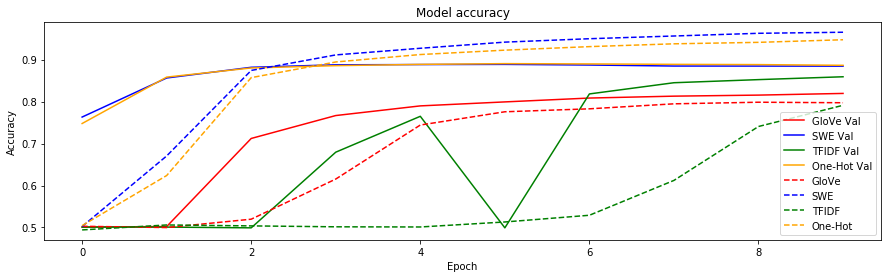

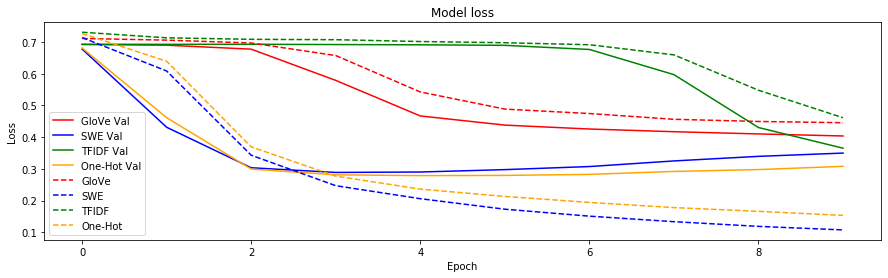

In [46]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
fig = plt.figure(figsize=(15, 4))
plt.plot(glove_history.history['val_acc'], color='red')
plt.plot(swe_history.history['val_acc'], color='blue')
plt.plot(tfidf_history.history['val_acc'], color='green')
plt.plot(oh_history.history['val_acc'], color='orange')

plt.plot(glove_history.history['acc'], ls='--', color='red')
plt.plot(swe_history.history['acc'], ls='--', color='blue')
plt.plot(tfidf_history.history['acc'], ls='--', color='green')
plt.plot(oh_history.history['acc'], ls='--', color='orange')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['GloVe Val', 'SWE Val', 'TFIDF Val', 'One-Hot Val', 'GloVe', 'SWE', 'TFIDF', 'One-Hot'], loc='best')
plt.show()

# Plot training & validation loss values
fig = plt.figure(figsize=(15, 4))
plt.plot(glove_history.history['val_loss'], color='red')
plt.plot(swe_history.history['val_loss'], color='blue')
plt.plot(tfidf_history.history['val_loss'], color='green')
plt.plot(oh_history.history['val_loss'], color='orange')

plt.plot(glove_history.history['loss'], ls='--', color='red')
plt.plot(swe_history.history['loss'], ls='--', color='blue')
plt.plot(tfidf_history.history['loss'], ls='--', color='green')
plt.plot(oh_history.history['loss'], ls='--', color='orange')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['GloVe Val', 'SWE Val', 'TFIDF Val', 'One-Hot Val', 'GloVe', 'SWE', 'TFIDF', 'One-Hot'], loc='best')
plt.show()


## Going Further

Now, if you know more about NLP, you probably know that this is really far from being comprehensive, or being state-of-the-art anymore. Word embeddings and language models have come a long way since _GloVe_ and _Word2Vec_.

[__fastText__](https://fasttext.cc/)

Facebook's open source system for word embeddings works in much the same way as _GloVe_, however, they are not static embeddings. They break down the words into Subword embeddings and thus work well with different spellings, misspellings, new words, different morphology, etc.

[__BERT__](https://arxiv.org/abs/1810.04805)

It's likely you have heard of _BERT_. _BERT_ has completely revolutionised NLP in the past couple years. Using an attention transformer network, BERT took a huge step towards solving the huge problem in NLP of _semantics_ and _context_. It creates dynamic embeddings of words based on their context, picking up differing senses.

Reearchers were able to beat almost every state-of-the-art metric out there with BERT embeddings. But a huge problem is that the models are quite large, and quite expensive to train and are sometimes overkill.

A smaller version of _BERT_ I quite like is [_RoBERTa_](https://pytorch.org/hub/pytorch_fairseq_roberta/)

